# Preamble

In [60]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datetime
import gmaps
import keyring
import math
import pickle
import pyproj
import random
import requests
import simpy
import unittest

from IPython import display
from pandas.plotting import register_matplotlib_converters
from shapely import geometry

register_matplotlib_converters()    
sns.set(style='darkgrid')

layout = {'width': '800px',
          'height': '800px',
          'border': '1px solid black',
          'padding': '1px'}

In [61]:
BING_MAPS_API_KEY = keyring.get_password('Microsoft', 'Bing Maps API')
GOOGLE_MAPS_API_KEY = keyring.get_password('Google', 'Maps Platform')
MAPBOX_MAPS_API_KEY = keyring.get_password('Mapbox', 'Mapbox API')

gmaps.configure(api_key=GOOGLE_MAPS_API_KEY)

In [62]:
with open('../data/bing_geojsons_restrictions.pickle', 'rb') as f:
    bing_geojsons_restrictions = pickle.load(f)
    
with open('../data/bing_geojsons_no_restrictions.pickle', 'rb') as f:
    bing_geojsons_no_restrictions = pickle.load(f)    

Latitude/longitude of Melbourne Emporium:

In [63]:
emporium_latitude = -37.8124448
emporium_longitude = 144.961366111

emporium = (emporium_latitude, emporium_longitude)

# Objectives

- Determine a suitable radius around specified locations (e.g. Emporium Melbourne) for time-constrained package delivery.


- In other words, given the location of a store, which people can order from the particular store.

# Scope of Work

- Monte Carlo simulator to determine the distribution of package delivery times for points of different distances from the origin.


- Support for aggregating traffic over different times and days so an accurate representation can be obtained.


- Point-to-point ETAs should be retrieved using the Google Maps Routing API or any other suitable alternative.

# Task 1: Isochrone

![Isochrone](https://www.dugwood.com/isochrone-screenshot.png?1562330360)

- An Isochrone is a boundary drawn on a map connecting destinations that can be reached from a given origin in the same amount of time


- Create an Isochrone that is reachable within 1-hour by electric scooter from Melbourne Emporium


- For an Isochrone to be representative, it should use traffic data from the operational hours of the service (as opposed to all times of the day)


- Generate an Isochrone for every hour that Emporium is open (10am - 7pm) and aggregate them


- Find best case, average case, worst case


- Since Isochrones are oddly shaped, we can summarise the size of the Isochrone by its average radius

## Bing (Skip)

In [5]:
def bing_isochrone(origin, departure_time=0, travel_time=60,
                   route_restrictions=True):
    """Find the Bing Isochrone given an origin, and departure and travel times.

    Note: using synchronous GET request against recommendation of documentation
    for Isochrone travel times greater than 30 minutes. Asynchronous GET
    requests seem to be buggy.

    Args:
      origin: Latitude/longitude of origin.
      departure_time: Desired time of departure in seconds.
      travel_time: Travel time used to define the Isochrone contour (in
                   minutes).
      route_restrictions: Boolean. If true will avoid highways and ferries.

    Returns:
      Bing Isochrone.
    """
    print('BING LIVE REQUEST')
    departure_datetime = datetime.datetime.fromtimestamp(departure_time)
    
    api_endpoint = 'http://dev.virtualearth.net/REST/v1/Routes/Isochrones'
    payload = {'waypoint': f'{origin[0]},{origin[1]}',
               'maxtime': travel_time,
               'timeUnit': 'minute',
               'travelMode': 'driving',
               'optimize': 'timeWithTraffic',
               'key': BING_MAPS_API_KEY}

    if departure_datetime:
        payload['dateTime'] = departure_datetime
        
    if route_restrictions:
        payload['avoid'] = 'highways,ferry'
        
    response = requests.get(api_endpoint, params=payload)
    
    # Convert response to GeoJSON
    coordinates = response.json()['resourceSets'][0]['resources'][0]['polygons'][0]['coordinates'][0]
    coordinates = [(long, lat) for (lat, long) in coordinates]  # GeoJSON expects long/lat.
    polygon = {'type': 'Polygon', 'coordinates': [coordinates]}
    isochrone = {'type': 'FeatureCollection',
                 'features': [{'properties': {'fillOpacity': 0.33,
                                              'color': '#bf4040',
                                              'fill': '#bf4040',
                                              'fillColor': '#bf4040',
                                              'contour': 60,
                                              'opacity': 0.33,
                                              'fill-opacity': 0.33},
                               'type': 'Feature', 
                               'geometry': polygon}]}
    
    return isochrone

Get Bing Isochrones every hour between midnight on 1 October 2019 and midnight on 9 October 2019:

In [6]:
# dates = pd.date_range(start='2019-10-01 00:00:00', end='2019-10-09 00:00', freq='H')

# bing_geojsons_restrictions = {str(date): bing_isochrone(emporium, date.timestamp()) for date in dates}
# with open('../data/bing_geojsons_restrictions.pickle', 'wb') as f:
#     pickle.dump(bing_geojsons, f, protocol=pickle.HIGHEST_PROTOCOL)

# bing_geojsons_no_restrictions = {str(date): bing_isochrone(emporium, date.timestamp()) for date in dates}
# with open('../data/bing_geojsons_no_restrictions.pickle', 'wb') as f:
#     pickle.dump(bing_geojsons_no_restrictions, f, protocol=pickle.HIGHEST_PROTOCOL)

## Mapbox (Skip)

In [7]:
def mapbox_isochrone(origin, travel_time=60):
    """Find the MapBox Isochrone given an origin and a travel time.
    
    Note: MapBox expects long/lat.

    Args:
      origin: Latitude/longitude of origin.
      travel_time: Travel time used to define the Isochrone contour (in
                   minutes).

    Returns:
      Mapbox Isochrone.
    """
    print('MAPBOX LIVE REQUEST')
    api_endpoint = f'https://api.mapbox.com/isochrone/v1/mapbox/driving/{origin[1]},{origin[0]}'
    payload = {'contours_minutes': travel_time,
               'polygons': 'true',
               'access_token': MAPBOX_MAPS_API_KEY}

    response = requests.get(api_endpoint, params=payload)
    return response.json()

## Helper Functions (Skip)

In [8]:
def geocode_address(address):
    print('GOOGLE GEOCODE LIVE REQUEST')
    api_endpoint = 'https://maps.googleapis.com/maps/api/geocode/json'
    payload = {'address': address,
               'key': GOOGLE_MAPS_API_KEY}
    
    response = requests.get(api_endpoint, params=payload)
    coords = response.json()['results'][0]['geometry']['location']
    return (coords['lat'], coords['lng'])

In [9]:
def generate_layers(origin, origin_name, geojsons_dict):
    origin_marker = gmaps.Marker(origin, info_box_content=origin_name)
    origin_marker_layer = gmaps.drawing_layer(features=[origin_marker])

    layers = {'origin': origin_marker_layer}

    colours = ['#ff0000', '#0000ff', '#00ff00']
    
    for index, (name, geojson) in enumerate(geojsons_dict.items()):
        layers[name] = gmaps.geojson_layer(geojson,
                                           fill_color='#000000',
                                           stroke_color=colours[index%len(colours)],
                                           fill_opacity=0.15)

    return layers

In [10]:
def random_coordinate(origin, r_metres=1000):
    """Samples a coordinate uniformly randomly given an origin and radius.
    
    The points are taken to be on a surface of a sphere. See:
    https://gis.stackexchange.com/questions/25877/generating-random-locations-nearby
    
    Also, the radius is converted from metres to degrees are the equator:
    https://en.wikipedia.org/wiki/Decimal_degrees

    Args:
      origin: Latitude, longitude pair.
      r_metres: Radius (in metres).

    Returns:
      Random latitude/longitude coordinate as a tuple.
    """
    r_degrees = r_metres / 111319.9
    
    x0 = origin[1]
    y0 = origin[0]

    u = random.uniform(0, 1)
    v = random.uniform(0, 1) 

    w = r_degrees * math.sqrt(u)
    t = 2 * math.pi * v
    x = w * math.cos(t)
    y = w * math.sin(t)
    
    # Adjust x-coordinate for shrinking of east-west distances with latitude.
    x_corrected = x / math.cos(y0)

    return (y + y0), (x_corrected + x0)


# coordinates = [random_coordinate(emporium, 40000)
#                for i in range(100)]

# coordinates = [(long, lat) for (lat, long) in coordinates]  # swap lat/lon

# fig, ax = plt.subplots(figsize=(16, 8))
# ax = sns.scatterplot(*zip(*coordinates))
# plt.scatter(emporium_longitude, emporium_latitude, color='red');
# ax.set_title('Uniform Distribution of 100 points 40 km from Melbourne Emporium', fontsize=14)
# ax.set_xlabel('Longitude',fontsize=14)
# ax.set_ylabel('Latitude',fontsize=14);

In [11]:
def random_datetime(start, end):
    """Generate a uniformly random datetime between start and end.
    
    Code from: https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-dates

    Args:
      start: start datetime.
      end: end datetime.

    Returns:
      Random datetime.
    """
    timedelta_seconds = random.randint(0, int((end - start).total_seconds()))
    return start + datetime.timedelta(seconds=timedelta_seconds)

# start = pd.to_datetime('2019-01-01 00:00:00').to_pydatetime()
# end = pd.to_datetime('2019-01-08 00:00:00').to_pydatetime()

# print(random_datetime(start, end))

## Isochrone Radius (Detail)

We are faced with the problem of calculating an estimate for the average radius of an irregular boundary (Isochrone) on the surface of a sphere.

Maps are 2D projections of the Earth's 3D surface, which distort features and distances when "flattening" the surface to form a map. We need to account for the curvature of the Earth over the isochrone when calculating the radius.

Most images in Mapping APIs use the Web Mercator projection, which was developed by Google to optimise serving of map data. It sub-divides the Earth's surface into square tiles of equal size by transforming the surface into a cylinder. Although accurately representing feature shapes at a local level, the drawback is that distances are highly distorted. The distortion increases with latitude, which is why Greenland appears to be of similar size to Africa, when in fact it has the land area of Saudi Arabia.

To calculate distances we use the Albers equal-area conic projection, since it minimises distortion of distances at mid-latitudes and preserves true areas. Instead of transforming the surface into a cylinder, the Albers projection transforms it into a cone with two standard parallels (latitudes where the cone touches the surface).

![Albers](https://www.icsm.gov.au/sites/default/files/inline-images/08-2896-12_0.jpg)
![Aus](https://www.icsm.gov.au/sites/default/files/inline-images/conic-comp.jpg)

To further increase the distance accuracy, we can customise the projection by selecting standard parallels directly North and South of an Isochrone over the package delivery origin. From the resulting projection, we are able to calculate the area of the Isochrone and estimate the average radius by assuming a circle centered around the origin with one quadrant removed to account for the Isochrone not extending into Port Phillip Bay.

In [12]:
def radius(geojson, origin):
    """Find the average radius (in kilometres) to the Isochrone contour.
    
    Args:
      geojson: Isochrone.
      origin: Latitude/longitude of origin.

    Returns:
      Average radius to the Isochrone contour.
    """
    # https://stackoverflow.com/questions/4681737/how-to-calculate-the-area-of-a-polygon-on-the-earths-surface-using-python
    coordinates = geojson['features'][0]['geometry']['coordinates'][0]
    lon, lat = zip(*coordinates)

    # Centre Albers Equal Area projection on Emporium
    p = pyproj.Proj(f'+proj=aea +lat_1={min(lat)} +lat_2={max(lat)} ' +
                    f'+lat_0={origin[0]} +lon_0={origin[1]}')
    x, y = p(lon, lat)
    shape = {'type': 'Polygon', 'coordinates': [zip(x, y)]}
    area = geometry.shape(shape).area  # square meters

    circle_area = area/3*4  # correction: assume Port Phillip Bay forms 1/4 of the circle
    radius = math.sqrt(circle_area/math.pi)
    return radius/1000  # in kilometeres

In [13]:
df = pd.DataFrame([{'date': pd.to_datetime(date), 'radius': radius(geojson, emporium)}
                   for date, geojson in bing_geojsons_restrictions.items()])
df.set_index('date', inplace=True)

Statistics:

In [14]:
widget = widgets.IntRangeSlider(value=(1000, 1900), # Emporium business hours
                                min=100,
                                max=2300,
                                step=100,
                                description='Hours: ',
                                continuous_update=False)

output1 = widgets.Output()
output1.layout.height = '240px'

def on_hours_description_change(change):
    start, end = change.new
    output1.clear_output()
    
    with output1:
        df_subset = df.between_time(str(start), str(end))
        print(df_subset.radius.describe())
        print('')
        print(f'Min radius occurs at: {df_subset.radius.idxmin()}')
        print(f'Max radius occurs at: {df_subset.radius.idxmax()}')

widget.observe(on_hours_description_change, names='value')
display.display(widget, output1)

IntRangeSlider(value=(1000, 1900), continuous_update=False, description='Hours: ', max=2300, min=100, step=100…

Output(layout=Layout(height='240px'))

In [15]:
widget = widgets.IntRangeSlider(value=(1000, 1900), # Emporium business hours
                                min=0,
                                max=2300,
                                step=100,
                                description='Hours: ',
                                continuous_update=False)

output2 = widgets.Output()
output2.layout.height = '400px'

def on_hours_plot_change(change):
    start, end = change.new
    output2.clear_output()
    
    with output2:
        df_subset = df.between_time(str(start), str(end))
        fig, ax = plt.subplots(figsize=(16, 6))
        ax = sns.lineplot(ax=ax, x=df_subset.index, y='radius', data=df_subset)
        ax.set_title('Radius vs. Date/Time', fontsize=14)
        ax.set_xlabel('Date',fontsize=14)
        ax.set_ylabel('Radius (km)', fontsize=14)
        plt.show()

widget.observe(on_hours_plot_change, names='value')
display.display(widget, output2)

IntRangeSlider(value=(1000, 1900), continuous_update=False, description='Hours: ', max=2300, step=100)

Output(layout=Layout(height='400px'))

In [16]:
widget = widgets.IntRangeSlider(value=(1000, 1900), # Emporium business hours
                                min=0,
                                max=2300,
                                step=100,
                                description='Hours: ',
                                continuous_update=False)

output3 = widgets.Output()
output3.layout.height = '400px'

def on_hours_distribution_change(change):
    start, end = change.new
    output3.clear_output()
    
    with output3:
        df_subset = df.between_time(str(start), str(end))
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.set(xlim=(0, 50), ylim=(0, 0.5))
        ax = sns.distplot(df_subset)
        ax.set_title('Radius Distribution', fontsize=14)
        ax.set_xlabel('Radius (km)',fontsize=14)
        plt.show()

widget.observe(on_hours_distribution_change, names='value')
display.display(widget, output3)

IntRangeSlider(value=(1000, 1900), continuous_update=False, description='Hours: ', max=2300, step=100)

Output(layout=Layout(height='400px'))

Note: it is interesting to see that the predictive traffic data used by Bing is the same when shifted by 7 days.

This is because Bing, like the other data providers, doesn't provide discrete traffic data for each day that has past. Instead, for any given time and day it provides an average speed of travel (from crowd sourced traffic data) for each section of the route, combined with known incidents. There is no transparency regarding how much historical data is used, or how much skewing is applied to more recent data.

In [ ]:
display.display(df[df.index >= '2019-10-01 00:00:00'].head())
display.display(df[df.index >= '2019-10-08 00:00:00'].head())

## Bing vs. Mapbox Isochrones

- Compare Bing and Mapbox Isochrones.


- Note: departure time and route restrictions and not applied since Mapbox doesn't have these options.

In [64]:
address_box_widget = widgets.Text(description='Address: ',
                                  continuous_update=False,
                                  layout={'width': '95%', 'margin': '10px 0 0 0'})
                                  
bing_widget = widgets.ToggleButton(description='Bing', button_style='')
mapbox_widget = widgets.ToggleButton(description='Mapbox', button_style='')

output4 = widgets.Output()
output4.layout.height = '816px'

origin = emporium
geojsons_dict4 = {'bing': bing_isochrone(emporium, route_restrictions=False),
                  'mapbox': mapbox_isochrone(emporium)}
layers = generate_layers(origin, 'Emporium', geojsons_dict4)

def on_api_change(bing, mapbox):
    output4.clear_output()
    
    global layers
    global origin

    with output4:
        melbourne_map = gmaps.figure(layout=layout, center=origin, zoom_level=9)
        melbourne_map.add_layer(layers['origin'])
        
        if bing:
            melbourne_map.add_layer(layers['bing'])
            
        if mapbox:
            melbourne_map.add_layer(layers['mapbox'])

        display.display(melbourne_map)

def on_bing_toggle(change):
    on_api_change(change.new, mapbox_widget.value)
    
def on_mapbox_toggle(change):
    on_api_change(bing_widget.value, change.new)

def on_address_submit(change):
    global layers
    global origin

    address = change.new
    origin = geocode_address(address)
    geojsons_dict4 = {'bing': bing_isochrone(origin, route_restrictions=False),
                      'mapbox': mapbox_isochrone(origin)}
    layers = generate_layers(origin, address, geojsons_dict4)
    on_api_change(bing_widget.value, mapbox_widget.value)     
    
bing_widget.observe(on_bing_toggle, names='value')
mapbox_widget.observe(on_mapbox_toggle, names='value')
address_box_widget.observe(on_address_submit, names='value')

# container = widgets.VBox([bing_widget, mapbox_widget, address_box_widget])
container = widgets.VBox([bing_widget, mapbox_widget])

display.display(container)
display.display(output4)

BING LIVE REQUEST
MAPBOX LIVE REQUEST


Output(layout=Layout(height='816px'))

## Bing Isochrones with/without Highways

- Compare Bing Isochrones with/without highways.

In [65]:
address_box_widget = widgets.Text(description='Address: ', 
                                  continuous_update=False,
                                  layout={'width': '95%', 'margin': '10px 0 0 0'})
                                  
bing_highway_widget = widgets.ToggleButton(description='Bing (Highway)', button_style='')
bing_no_highway_widget = widgets.ToggleButton(description='Bing (No Highway)', button_style='')

output7 = widgets.Output()
output7.layout.height = '816px'

origin = emporium
geojsons_dict7 = {'highway': bing_isochrone(origin, route_restrictions=False),
                  'no_highway': bing_isochrone(origin, route_restrictions=True)}
layers = generate_layers(origin, 'Emporium', geojsons_dict7)

def on_highway_change(highway, no_highway):
    output7.clear_output()
    
    global layers
    global origin

    with output7:
        melbourne_map = gmaps.figure(layout=layout, center=origin, zoom_level=9)
        melbourne_map.add_layer(layers['origin'])
        
        if highway:
            melbourne_map.add_layer(layers['highway'])
            
        if no_highway:
            melbourne_map.add_layer(layers['no_highway'])

        display.display(melbourne_map)

def on_highway_toggle(change):
    on_highway_change(change.new, bing_no_highway_widget.value)
    
def on_no_highway_toggle(change):
    on_highway_change(bing_highway_widget.value, change.new)

def on_address_submit(change):
    global layers
    global origin

    address = change.new
    origin = geocode_address(address)
    geojsons_dict7 = {'highway': bing_isochrone(origin, route_restrictions=False),
                      'no_highway': bing_isochrone(origin, route_restrictions=True)}
    layers = generate_layers(origin, address, geojsons_dict7)
    on_highway_change(bing_highway_widget.value, bing_no_highway_widget.value)     
    
bing_highway_widget.observe(on_highway_toggle, names='value')
bing_no_highway_widget.observe(on_no_highway_toggle, names='value')
address_box_widget.observe(on_address_submit, names='value')

container = widgets.VBox([bing_highway_widget, bing_no_highway_widget])
# container = widgets.VBox([bing_highway_widget, bing_no_highway_widget, address_box_widget])

display.display(container)
display.display(output7)

BING LIVE REQUEST
BING LIVE REQUEST


Output(layout=Layout(height='816px'))

### Restriction Issues

- Closer examination of Bing traffic levels per hour traffic levels aggregated over a 8-day period shows a discrepancy in night time traffic levels.

In [41]:
df_restrictions = pd.DataFrame([{'date': pd.to_datetime(date), 'radius': radius(geojson, emporium)}
                                for date, geojson in bing_geojsons_restrictions.items()])
df_restrictions.set_index('date', inplace=True)

df_no_restrictions = pd.DataFrame([{'date': pd.to_datetime(date), 'radius': radius(geojson, emporium)}
                                   for date, geojson in bing_geojsons_no_restrictions.items()])
df_no_restrictions.set_index('date', inplace=True)

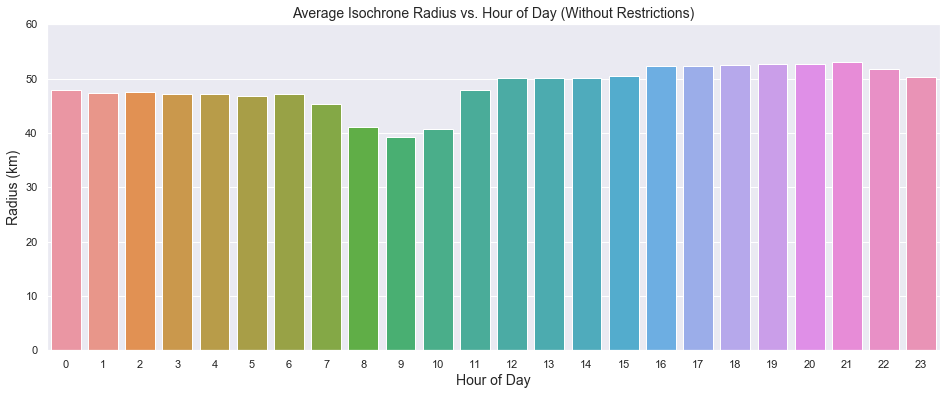

In [57]:
df_no_restrictions_hours = df_no_restrictions.radius.groupby(df_no_restrictions.index.hour).mean()
fig, ax = plt.subplots(figsize=(16, 6))
ax.set(xlim=(0, 24), ylim=(0, 60))
ax = sns.barplot(df_no_restrictions_hours.index, df_no_restrictions_hours.values)
ax.set_title('Average Isochrone Radius vs. Hour of Day (Without Restrictions)', fontsize=14)
ax.set_xlabel('Hour of Day',fontsize=14)
ax.set_ylabel('Radius (km)',fontsize=14)
plt.show()

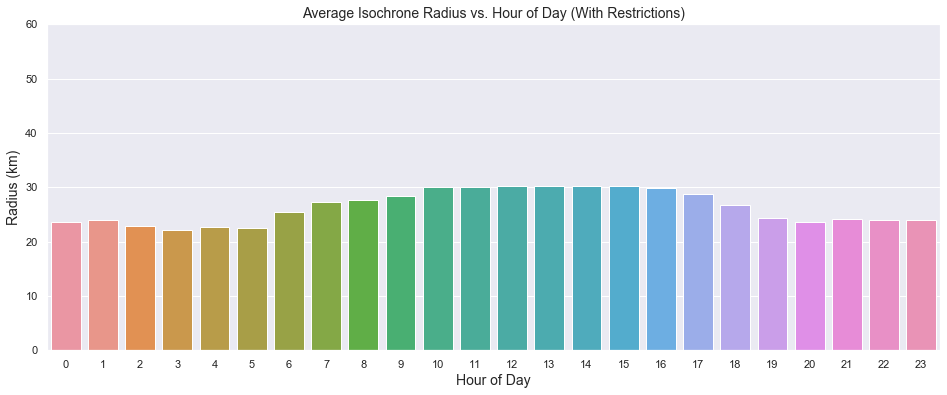

In [58]:
df_restrictions_hours = df_restrictions.radius.groupby(df_restrictions.index.hour).mean()
fig, ax = plt.subplots(figsize=(16, 6))
ax.set(xlim=(0, 24), ylim=(0, 60))
ax = sns.barplot(df_restrictions_hours.index, df_restrictions_hours.values)
ax.set_title('Average Isochrone Radius vs. Hour of Day (With Restrictions)', fontsize=14)
ax.set_xlabel('Hour of Day',fontsize=14)
ax.set_ylabel('Radius (km)',fontsize=14)
plt.show()

- We hypothesise that this is due to limited data points at night time.


- Data should be suffient for business hours


- Traffic data providers that don't have Google's comprehensive install base usually rely on commercial agreements with taxi/delivery companies for data.

## Bing Extrema Isochrones

- Compare Bing Isochrones for rush hour vs. normal traffic:

In [70]:
route_restrictions=True

address_box_widget = widgets.Text(description='Address: ', 
                                  continuous_update=False,
                                  layout={'width': '95%', 'margin': '10px 0 0 0'})
                                  
min_widget = widgets.ToggleButton(description='Minimum', button_style='')
max_widget = widgets.ToggleButton(description='Maximum', button_style='')

output5 = widgets.Output()
output5.layout.height = '816px'

origin = emporium
geojsons_dict5 = {'min': bing_isochrone(origin,
                                        departure_time=pd.to_datetime('2019-10-01 09:00:00').timestamp(),
                                        route_restrictions=route_restrictions),
                  'max': bing_isochrone(origin,
                                        departure_time=pd.to_datetime('2019-10-01 14:00:00').timestamp(),
                                        route_restrictions=route_restrictions)}
layers = generate_layers(origin, 'Emporium', geojsons_dict5)

def on_min_max_change(min_, max_):
    output5.clear_output()
    
    global layers
    global origin

    with output5:
        melbourne_map = gmaps.figure(layout=layout, center=origin, zoom_level=9)
        melbourne_map.add_layer(layers['origin'])
        
        if min_:
            melbourne_map.add_layer(layers['min'])
            
        if max_:
            melbourne_map.add_layer(layers['max'])

        display.display(melbourne_map)

def on_min_toggle(change):
    on_min_max_change(change.new, max_widget.value)
    
def on_max_toggle(change):
    on_min_max_change(min_widget.value, change.new)

def on_address_submit(change):
    global layers
    global origin

    address = change.new
    origin = geocode_address(address)
    geojsons_dict5 = {'min': bing_isochrone(origin, departure_time=pd.to_datetime('2019-10-01 09:00:00').timestamp(), route_restrictions=route_restrictions),
                      'max': bing_isochrone(origin, departure_time=pd.to_datetime('2019-10-01 14:00:00').timestamp(), route_restrictions=route_restrictions)}
    layers = generate_layers(origin, address, geojsons_dict5)
    on_min_max_change(min_widget.value, max_widget.value)     
    
min_widget.observe(on_min_toggle, names='value')
max_widget.observe(on_max_toggle, names='value')
address_box_widget.observe(on_address_submit, names='value')

container = widgets.VBox([min_widget, max_widget, address_box_widget])

display.display(container)
display.display(output5)

BING LIVE REQUEST
BING LIVE REQUEST


Output(layout=Layout(height='816px'))

## Bing Isochrones with Travel Time Adjustment

In [67]:
emporium_marker = gmaps.Marker((emporium_latitude, emporium_longitude),
                               info_box_content='Emporium')
emporium_marker_layer = gmaps.drawing_layer(features=[emporium_marker])

travel_time_widget = widgets.IntSlider(value=60,
                                       min=0,
                                       max=120,
                                       step=1,
                                       description='Travel Time:',
                                       continuous_update=False)

output8 = widgets.Output()
output8.layout.height = '816px'

def on_travel_time_change(change):
    output8.clear_output()

    with output8:
        melbourne_map = gmaps.figure(layout=layout, center=emporium, zoom_level=10)
        melbourne_map.add_layer(emporium_marker_layer)
        
        geojson = bing_isochrone(emporium,
                                 departure_time=pd.to_datetime('2019-10-07 12:00:00').to_pydatetime().timestamp(),
                                 travel_time=change.new)
        
        isochrone_layer = gmaps.geojson_layer(geojson,
                                              fill_color='#000000',
                                              stroke_color='#ff0000',
                                              fill_opacity=0.15)
            
            
        melbourne_map.add_layer(isochrone_layer)
        display.display(melbourne_map)

travel_time_widget.observe(on_travel_time_change, names='value')
display.display(travel_time_widget, output8)

IntSlider(value=60, continuous_update=False, description='Travel Time:', max=120)

Output(layout=Layout(height='816px'))

## Conclusion

### Overview

- We assessed the following Mapping APIs:
    - Google Maps
    - Microsoft Bing
    - Mapbox
    - TomTom
    - Here Maps


- Bing Maps was overall the most suitable for this part of the study, as it included:
    - Isochrone API;
    - parameter to avoid highways and ferries; and
    - parameter for departure time that uses historical traffic data to predict trip duration
    
    
- When considering traffic data exclusively, however, Google Maps API has the most comprehensive data. This is with regard to both road network coverage as well as quantity of crowd-sourced data, due to it's dominant market share.
Unfortunately they do not provide an isochrone API, which made it unsuitable for this part of the study. However it will be used for the simulation in the next part.


- All of the Mapping APIs shared a significant drawback: none of the standard travel modes (e.g. car, bicycle) can accurately model the traffic speed and routes taken by an electric scooter.
    - electric scooters can weave through traffic (deviating from the car model)
    - electric scooters are unable to use cycle paths (deviating from the bicycle model)


- The Kymco scooter is unsuitable for highways since it has a low top speed of 45 km/h, so turning on the parameter to avoid highways is necessary.


- The estimates in the next section are based on a car driving in traffic which may differ from electric scooters in the following ways:
    - cars are capable of a slightly higher top speed on uncongested city roads
    - electric scooters can weave through traffic

### Recommendations and further work

1. The available data suggests that the operational radius should be limited to:

    - 31.9 km (best case)
    - 29.1 km (average case)
    - 20.1 km (worst case)

    These limits are based on:
    - Isochrone travel times of 1-hour during Emporium business hours (10am - 7pm)
    - Taking into account average traffic levels
    - Zero downtime for package pickup and dropoff and electric scooter charging


2. Using a highway-capable scooter would greatly increase the operational area

    - 53.5 km (best case)
    - 49.9 km (average case)
    - 35.1 km (worst case)
    

3. As previously discussed, these numbers should be taken as rough estimates. Acheiving a more robust model will require implementation of an application-specific data gathering regime. Specifically running randomised trial routes using the intended vehicle at various times throughout the operational period.


4. A system based on an offline open source routing engine (e.g. Graphhopper) will allow us to build a custom model for how an electric scooter interacts with traffic and what routes it can take. By taking control of the code base, data from the test regime can be combined with historical traffic data to calculate trip duration predictions. This can be continuously refined with operational data to achieve increasing levels of accuracy. This is in contrast to relying solely on web APIs which are "black boxes" that can only partially model the use case.

# Task 2: Simulated Deliveries

- Determine the number of packages that can be delivered by one driver in a typical day.


- Simulate a sequence of deliveries with one driver making multiple deliveries throughout the day for a given delivery radius.


- Compute best case, average case and worst case scenarios.

## Step 1: Simulate Delivery Locations

The following function generates random delivery points within a given Isochrone, allowing us to compare different times of day or days of week:

In [71]:
def generate_random_coordinates(n, polygon):
    """Generates point coordinates uniformly randomly inside a given polygon.

    Args:
      n: The number of coordinates to generate.
      polygon: The polygon (shapely.geometry.polygon.Polygon) that defines the
               boundary of the area within which coordinates will be generated.

    Returns:
      List of random latitude/longitude coordinate as tuples.
    """
    x_min, y_min, x_max, y_max = polygon.bounds

    
    points = []
    while len(points) < n:
        points.extend([geometry.Point(random.uniform(x_min, x_max),
                                      random.uniform(y_min, y_max))
                       for i in range(n)])
    
        # Filter points.
        points = [point for point in points if polygon.contains(point)]
    
    coordinates = [(point.y, point.x) for point in points][:n]
    assert len(coordinates) == n
    return coordinates

In [74]:
polygon = geometry.shape(bing_geojsons_restrictions['2019-10-03 09:00:00']['features'][0]['geometry'])

random_coordinates = generate_random_coordinates(100, polygon)

emporium_marker = gmaps.Marker((emporium_latitude, emporium_longitude),
                               info_box_content='Emporium')
emporium_marker_layer = gmaps.drawing_layer(features=[emporium_marker])

isochrone_layer = gmaps.geojson_layer(bing_geojsons_restrictions['2019-10-03 09:00:00'],
                                      fill_color='#000000',
                                      stroke_color='#ff0000',
                                      fill_opacity=0.15)

coordinate_widget = widgets.IntSlider(value=10,
                                      min=0,
                                      max=100,
                                      step=1,
                                      description='Coordinates:',
                                      continuous_update=False)

output6 = widgets.Output()
output6.layout.height = '816px'

def on_coordinates_change(change):
    output6.clear_output()
    n = change.new
    coordinates_layer = gmaps.symbol_layer(random_coordinates[:n],
                                           fill_color='#ff0000',
                                           stroke_color='#ff0000',
                                           scale=2)

    with output6:
        melbourne_map = gmaps.figure(layout=layout, center=emporium, zoom_level=10)
        melbourne_map.add_layer(emporium_marker_layer)
        melbourne_map.add_layer(isochrone_layer)
        melbourne_map.add_layer(coordinates_layer)
        display.display(melbourne_map)

coordinate_widget.observe(on_coordinates_change, names='value')
display.display(coordinate_widget, output6)

IntSlider(value=10, continuous_update=False, description='Coordinates:')

Output(layout=Layout(height='816px'))

Function to calculate trip durations:

In [ ]:
def google_duration(origin, destination, departure_time, testing=True,
                    traffic=False, mode='driving'):
    """Find the length of time required to travel a route.
    
    Note: each live request costs US$0.005 (without traffic) and US$0.01 (with
    traffic).

    Args:
      origin: Latitude/longitude of origin.
      destination: Latitude/longitude of destination.
      departure_time: Desired time of departure in seconds (must be either
                      current time or time in future).
      testing: Use a randomly generated duration instead of sending a live
               request.
      traffic: Use traffic information in the request.
      mode: Travel mode (driving, walking, bicycling or transit).

    Returns:
      Duration in seconds.
    """
    if testing:
        return random.randrange(600, 3600)
    else:
        print('GOOGLE LIVE REQUEST')
        api_endpoint = 'https://maps.googleapis.com/maps/api/distancematrix/json'
        payload = {'origins': f'{origin[0]},{origin[1]}',
                   'destinations': f'{destination[0]},{destination[1]}',
                   'mode': mode,
                   'avoid': 'highways',
                   'key': GOOGLE_MAPS_API_KEY}

        if traffic:
            payload['departure_time'] = int(departure_time),  
            key = 'duration_in_traffic'
        else:
            key = 'duration'

        response = requests.get(api_endpoint, params=payload)
        return response.json()['rows'][0]['elements'][0][key]['value']

## Step 2: Run Simulation

- To implement the simulation, we create an environment object that represents a working day. We use the delivery locations and trip durations between these locations to simulate a rider making consecutive package deliveries. 


- The driver will travel back and forth between the origin and different delivery locations until the end of the business day. We tally the number of successfully completed trips. 


- In order to obtain a representative distribution of the number of deliveries per day, we simulate multiple iterations with randomly generated delivery locations for each iteration.

In [ ]:
def scooter(env, polygon, turnaround_duration=120, verbose=False, testing=True):
    """Simulates trips that a single scooter can complete in a given
    timeframe (specified by env) for a set of randomly generated client
    locations within the provided isochrone.

    Args:
      env: Environment object used to simulate date time.
      polygon: The polygon (shapely.geometry.polygon.Polygon) that defines the
          boundary of the area within which client coordinates will be
          generated.
      turnaround_time: Estimated scooter turnaround time to be added to
          outbound and return durations.
    """
    while True:
        customer = generate_random_coordinates(1, polygon)[0]
        
        # Outbound trip
        start_time = datetime.datetime.fromtimestamp(env.now)    
        outbound_duration = google_duration(emporium, customer, env.now, testing=testing, traffic=False)
        yield env.timeout(outbound_duration + turnaround_duration)

        if verbose:
            print(f'Start outbound trip from {emporium} to {customer} at {start_time}')

        # Inbound trip
        start_time = datetime.datetime.fromtimestamp(env.now)
        inbound_duration = google_duration(customer, emporium, env.now, testing=testing, traffic=False)
        yield env.timeout(inbound_duration + turnaround_duration)
        
        if verbose:
            print(f'Start inbound trip from {customer} to {emporium} at {start_time}')

        global trips
        trips += 1

In [ ]:
def simulate(date, polygon, start_hour=10, end_hour=19):
    start = date.replace(hour=start_hour).timestamp()
    end = date.replace(hour=end_hour).timestamp()
    
    global trips
    trips = 0
    
    env = simpy.Environment(initial_time=start)
    env.process(scooter(env, polygon, trips))
    env.run(until=end)
    
    return trips

In [ ]:
iterations = 10
polygon = geometry.shape(bing_geojsons['2019-10-03 09:00:00']['features'][0]['geometry'])
dates = pd.date_range(start='2019-10-01', end='2019-10-01')

trip_simulation = {str(date): [simulate(date, polygon)
                               for i in range(iterations)]
                   for date in dates}

trips = [trip for trips in trip_simulation.values() for trip in trips]

print(f'Results from a {iterations}-iteration simulation:')
print(f'Best case: {max(trips)} trips')
print(f'Average case: {sum(trips)/len(trips):.3} trips')
print(f'Worst case: {min(trips)} trips')

## Conclusion

### Overview

Results from a 10-iteration simulation:
- Best case: 9 trips
- Average case: 5.9 trips
- Worst case: 5 trips

### Insights

- Dispatch algorithm improvements like Batched Matching and Trip Upgrade can result in more trips.


- Decreasing Isochrone radius decreases demand since scooters now reach fewer people.


- Assuming unlimited demand, it is always better to use a smaller radius (shorter trips mean more trips are possible).


- Can assess how demand changes with radius by collecting data.

# Appendix

## How to Create API Keys

### Bing

- Go to the Bing Maps Dev Centre (https://www.bingmapsportal.com)
- Click 'Sign in' 
- If you have a Bing Maps account, sign in with the Microsoft account that you used to create the account or create a new one
- Select My keys under My Account
- Select the option to create a new key
- For Application name, enter an easy to remember name
- Leave  Application URL blank
- For the Key type select 'Basic'
- For the Application type select Dev/Test
- Click the Create button
- The new key displays in the list of available keys

Run:

In [ ]:
keyring.set_password('Microsoft', 'Bing Maps API', BING_MAPS_API_KEY)

### Google

- Create a Google Cloud Plaform account (https://cloud.google.com/)
- Open the GCP Console (https://console.cloud.google.com/google/maps-apis/overview)
- Click the project drop-down and select the Directions API
- Click the menu button and select APIs & Services > Credentials
- On the Credentials page, click Create credentials > API key
- The API key created dialog displays your newly created API key
- Click Close
- The new API key is listed on the Credentials page under API keys

Run:

In [ ]:
keyring.set_password('Google', 'Maps Platform', GOOGLE_MAPS_API_KEY)

### Mapbox

- Create a Mapbox account (https://account.mapbox.com/auth/signup/)
- On your account dashboard, click Create a Token (https://account.mapbox.com/access-tokens/)
- Give the token an easy to remember name and leave everything else as default
- Click Create token
- On tokens page copy the public token

Run:

In [ ]:
keyring.set_password('Mapbox', 'Mapbox API', MAPBOX_MAPS_API_KEY)

# Scratchpad

In [75]:
df_restrictions = pd.DataFrame([{'date': pd.to_datetime(date), 'radius': radius(geojson, emporium)}
                                for date, geojson in bing_geojsons_restrictions.items()])
df_restrictions.set_index('date', inplace=True)

df_no_restrictions = pd.DataFrame([{'date': pd.to_datetime(date), 'radius': radius(geojson, emporium)}
                                   for date, geojson in bing_geojsons_no_restrictions.items()])
df_no_restrictions.set_index('date', inplace=True)

In [80]:
df_restrictions_subset = df_restrictions.between_time('1000', '1900')
df_no_restrictions_subset = df_no_restrictions.between_time('1000', '1900')

In [78]:
df_restrictions_subset.describe()

,radius
count,80.000000
mean,29.089228
std,3.913352
min,20.066710
25%,29.134974
50%,31.204633
75%,31.665596
max,31.884176


In [81]:
df_no_restrictions_subset.describe()

,radius
count,80.000000
mean,49.873903
std,3.885029
min,35.114148
25%,49.843235
50%,50.442570
75%,52.213086
max,53.531819
